In [338]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime

         Date   Time  Open  High  Low  Close
0  2022-01-04  09:00   203   218  179    207
1  2022-01-04  10:00   217   221  186    189
2  2022-01-04  11:00   189   228  189    227
3  2022-01-04  12:00   227   228  194    225
4  2022-01-04  13:00   225   231  195    224


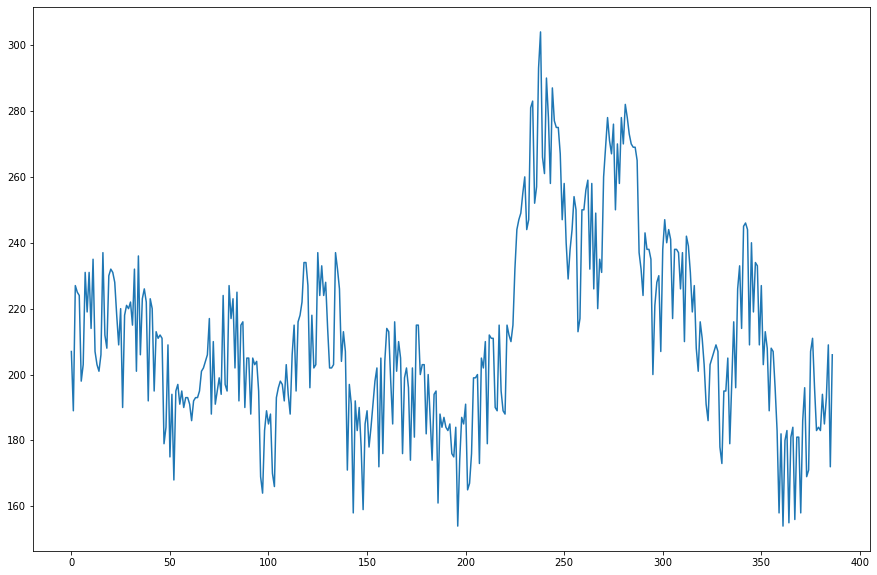

In [381]:
# Read the csv file
df = pd.read_csv('./clean_data/integrated_candlesticks3600.csv')
print(df.head())
price = df.Close
fig, ax = plt.subplots(figsize=(15, 10))
x = range(len(price))
plt.plot(x, price)
# plt.xlim([200, 400])
plt.show()

In [382]:
# preprocessing 
# select cols [2:6]
cols = list(df)[2:6]
df_4cols = df[cols].astype(float)

# split train test
split_rate = 0.7
split_index = int(len(df)*0.7)
unscaled_train_df = df_4cols.iloc[:split_index]
unscaled_test_df = df_4cols.iloc[split_index+1:]

# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(unscaled_train_df)
train_df = scaler.transform(unscaled_train_df)
test_df = scaler.transform(unscaled_test_df)

print(unscaled_train_df.head())
print(unscaled_test_df.head())

print(np.shape(train_df))
print(np.shape(test_df))

    Open   High    Low  Close
0  203.0  218.0  179.0  207.0
1  217.0  221.0  186.0  189.0
2  189.0  228.0  189.0  227.0
3  227.0  228.0  194.0  225.0
4  225.0  231.0  195.0  224.0
      Open   High    Low  Close
271  259.0  273.0  234.0  269.0
272  269.0  279.0  236.0  278.0
273  278.0  279.0  239.0  271.0
274  273.0  278.0  241.0  267.0
275  271.0  280.0  241.0  276.0
(270, 4)
(116, 4)


In [383]:
# Empty lists to be populated using formatted training data
trainX = []
trainY = []
testX = []
testY = []

n_future = 2   # Number of days we want to look into the future based on the past days.
n_past = 20  # Number of past days we want to use to predict the future.

# Reformat input data into a shape: (n_samples x timesteps x n_features)
# reformat train
for i in range(n_past, len(train_df) - n_future +1):
    trainX.append(train_df[i - n_past:i, 0:train_df.shape[1]])
    trainY.append(train_df[i + n_future - 1:i + n_future, 0])
# reformat test
for i in range(n_past, len(test_df) - n_future +1):
    testX.append(test_df[i - n_past:i, 0:test_df.shape[1]])
    testY.append(test_df[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (249, 20, 4).
trainY shape == (249, 1).
testX shape == (95, 20, 4).
testY shape == (95, 1).


In [384]:
# define model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 20, 64)            17664     
_________________________________________________________________
lstm_43 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


Train on 224 samples, validate on 25 samples
Epoch 1/30
224/224 [==============================] - 7s 31ms/sample - loss: 0.7946 - val_loss: 2.0741
Epoch 2/30
224/224 [==============================] - 0s 634us/sample - loss: 0.6859 - val_loss: 1.3951
Epoch 3/30
224/224 [==============================] - 0s 634us/sample - loss: 0.5829 - val_loss: 0.6717
Epoch 4/30
224/224 [==============================] - 0s 589us/sample - loss: 0.4890 - val_loss: 2.9308
Epoch 5/30
224/224 [==============================] - 0s 627us/sample - loss: 0.4893 - val_loss: 6.8284
Epoch 6/30
224/224 [==============================] - 0s 674us/sample - loss: 0.4430 - val_loss: 7.1285
Epoch 7/30
224/224 [==============================] - 0s 625us/sample - loss: 0.4707 - val_loss: 3.5484
Epoch 8/30
224/224 [==============================] - 0s 612us/sample - loss: 0.4533 - val_loss: 1.4151
Epoch 9/30
224/224 [==============================] - 0s 627us/sample - loss: 0.4103 - val_loss: 1.2736
Epoch 10/30
224/224 

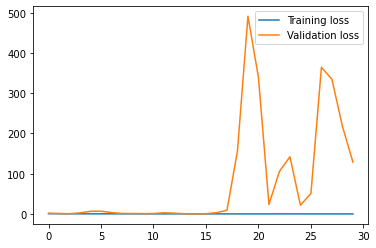

In [385]:
# fit the model
history = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [386]:
# fit on training set
pred_trainY = []
for sample in trainX:
    pred_trainY.append(model.predict(np.reshape(sample,(1,n_past,trainX.shape[2]))))
print(np.shape(pred_trainY))
print(np.shape(true_y))

# inverse pre_trainY
pred_trainY = np.reshape(np.array(pred_trainY), (len(pred_trainY),1))
prediction_copies = np.repeat(pred_trainY, trainX.shape[2], axis=-1)
pred_trainY = scaler.inverse_transform(prediction_copies)[:,0]
print(pred_trainY[:5])

(249, 1, 1)
(438,)
[219.65083 220.22365 220.27977 219.85048 216.65346]


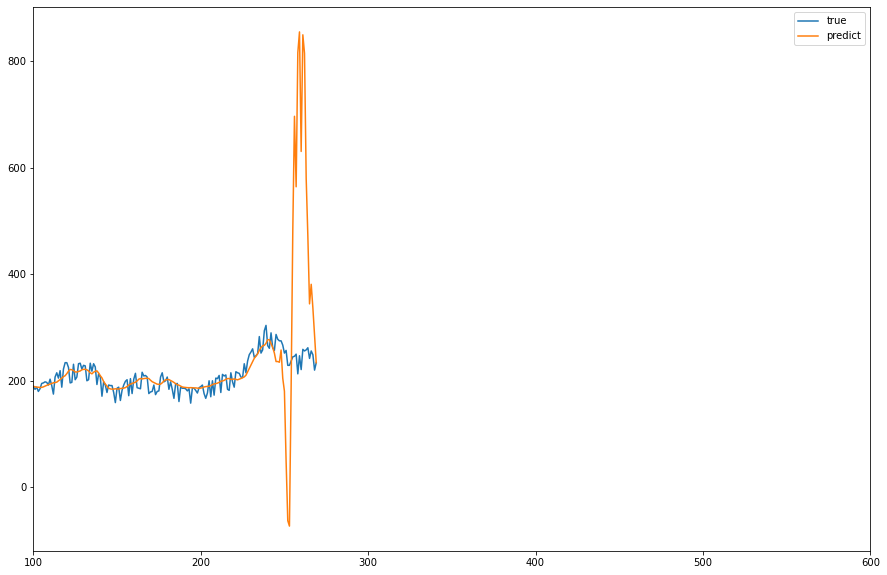

In [387]:
# plot prediction fit in train set
time_start = 100
time_end = 600

fig, ax = plt.subplots(figsize=(15, 10))
x=range(len(train_df))
true_y = unscaled_train_df['Open']
plt.plot(x, true_y, label='true')
plt.plot(x[n_past+1:], pred_trainY, label='predict')
plt.legend()
plt.xlim([time_start, time_end])
plt.show()

In [388]:
# # fit in test set
# pred_testY = []
# for sample in testX:
#     pred_testY.append(model.predict(np.reshape(sample,(1,n_past,trainX.shape[2]))))
# print(np.shape(pred_testY))

# # inverse pred_testY
# pred_testY = np.reshape(np.array(pred_testY), (len(pred_testY),1))
# prediction_copies = np.repeat(pred_testY, testX.shape[2], axis=-1)
# pred_testY = scaler.inverse_transform(prediction_copies)[:,0]
# print(pred_trainY[:5])

In [389]:
print(testX[3])

[[2.37213709 2.08974164 2.15464638 2.12164588]
 [2.29799064 2.16560962 2.15464638 2.45566593]
 [2.40921031 2.20354362 2.19474526 1.49071911]
 [2.63164965 2.39321359 2.4754374  2.23298589]
 [2.7057961  2.54494957 2.63583292 1.78762583]
 [1.77896551 2.54494957 2.63583292 2.52989261]
 [2.55750321 2.43114759 2.43533853 2.23298589]
 [2.22384419 2.27941161 2.39523965 2.67834596]
 [2.66872288 2.27941161 2.15464638 2.52989261]
 [2.55750321 2.12767563 2.15464638 2.34432591]
 [2.18677097 2.01387365 1.99425087 2.23298589]
 [2.26091742 1.82420367 1.71355872 2.19587255]
 [2.0755513  1.82420367 1.99425087 2.19587255]
 [2.22384419 1.78626968 1.91405311 2.0474192 ]
 [2.0755513  1.5965997  1.67345984 1.00824571]
 [0.96335458 1.6345337  1.43286657 0.82267901]
 [0.88920814 1.44486372 1.47296545 0.5257723 ]
 [0.59262235 1.21725975 0.91158116 1.23092574]
 [0.14774366 0.76205181 0.71108677 1.04535905]
 [1.07457426 0.79998581 0.8313834  1.04535905]]


In [390]:
# n_future > 2
n_future = 10
pred_testY = []
for sample_index in range(0,len(testX)-n_future,n_future):
    for n in range(n_future):
        tmp = testX[sample_index+n]
        if n != 0:
            tmp[-n:,:] = pred_testY[sample_index:sample_index+n]
            # tmp[-n:,1:4] = 0
        pred_testY.append(model.predict(np.reshape(tmp,(1,n_past,trainX.shape[2]))))

D:\Program Files\anaconda3\envs\trader\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  


In [391]:
# inverse pred_testY
pred_testY = np.reshape(np.array(pred_testY), (len(pred_testY),1))
prediction_copies = np.repeat(pred_testY, testX.shape[2], axis=-1)
pred_testY = scaler.inverse_transform(prediction_copies)[:,0]
print(pred_testY[:5])
true_y = unscaled_test_df['Open']
print(true_y[:5])

[ -10.5765705 -377.19394   -269.12564   -358.98947   -486.37747  ]
271    259.0
272    269.0
273    278.0
274    273.0
275    271.0
Name: Open, dtype: float64


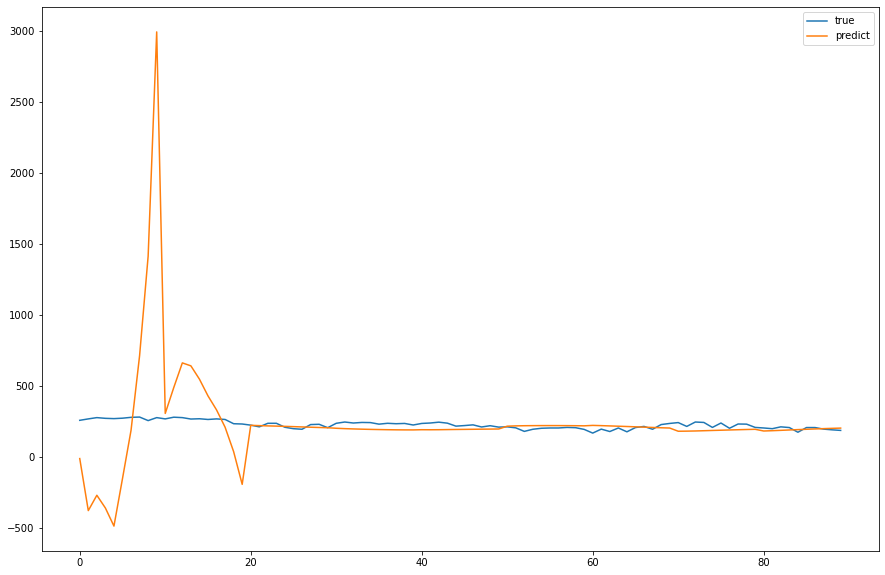

In [392]:
# plot prediction fit in train set
time_start = 100 
time_end = 500

x=range(len(pred_testY))
true_y = unscaled_test_df['Open']
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(x, true_y[:len(pred_testY)], label='true')
plt.plot(x, pred_testY, label='predict')
plt.legend()
# plt.xlim([time_start, time_end])
plt.show()

In [393]:
# evaluate
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(true_y[n_past:], pred_testY))
print(rmse)

ValueError: Found input variables with inconsistent numbers of samples: [96, 90]

In [ ]:
# tuning n_future > 2 



